In [1]:
import json
from os import listdir
from os.path import join
import pandas as pd
import networkx as nx

from typing import List

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def load_json_dir (directory: str) -> List[dict]: 
    '''
    Load each file in a directory of JSON files
    '''
    filenames = listdir(directory)
    def load_by_fn (fn: str) -> dict:
        return json.load(open(join(directory, fn)))
    return [load_by_fn(f) for f in filenames if f != 'search.json']

# By country

In [3]:
countries = load_json_dir('www.submarinecablemap.com/public/api/v2/country/')

In [4]:
# countries[5]

In [5]:
def get_connections (country):
    landings = country['landing_points']
    names = [l['name'] for l in landings]
    return names

place_names = get_connections(countries[5])
# place_names

## Placename to cc

In [6]:
cc_codes = pd.read_csv('country_to_cc.csv')

def country_to_cc2 (country_name: str) -> str:
    try:
        return cc_codes[cc_codes['Country']==country_name]['Alpha-2 code'].values[0].split('"')[1]
    except:
        raise Exception(f'Cannot find {country_name}')

In [7]:
def place_name_to_cc2 (placename: str) -> str:
    try:
        count_name = placename.split(',')[-1].strip()
        return country_to_cc2(count_name)
    except:
        # sometimes country names have a comma (e.g., 'Congo, Dem. Rep.')
        count_name = placename.split(',')[-2].strip()
        return country_to_cc2(count_name)
# [place_name_to_cc2(n) for n in place_names]

# Make a graph for the whole world

In [8]:
G = nx.Graph()
for country in countries:
    cc2 = country_to_cc2(country['name'])
    # add nodes for each country
    G.add_node(cc2)
for country in countries:
    # add edges for each country
    from_cc2 = country_to_cc2(country['name'])
    connection_names = get_connections(country)
    connection_cc2s = [place_name_to_cc2(n) for n in connection_names]
    for to_cc2 in connection_cc2s:
        G.add_edge(from_cc2, to_cc2)

# Analyze the graph of the world

https://programminghistorian.org/en/lessons/exploring-and-analyzing-network-data-with-python#the-shape-of-the-network

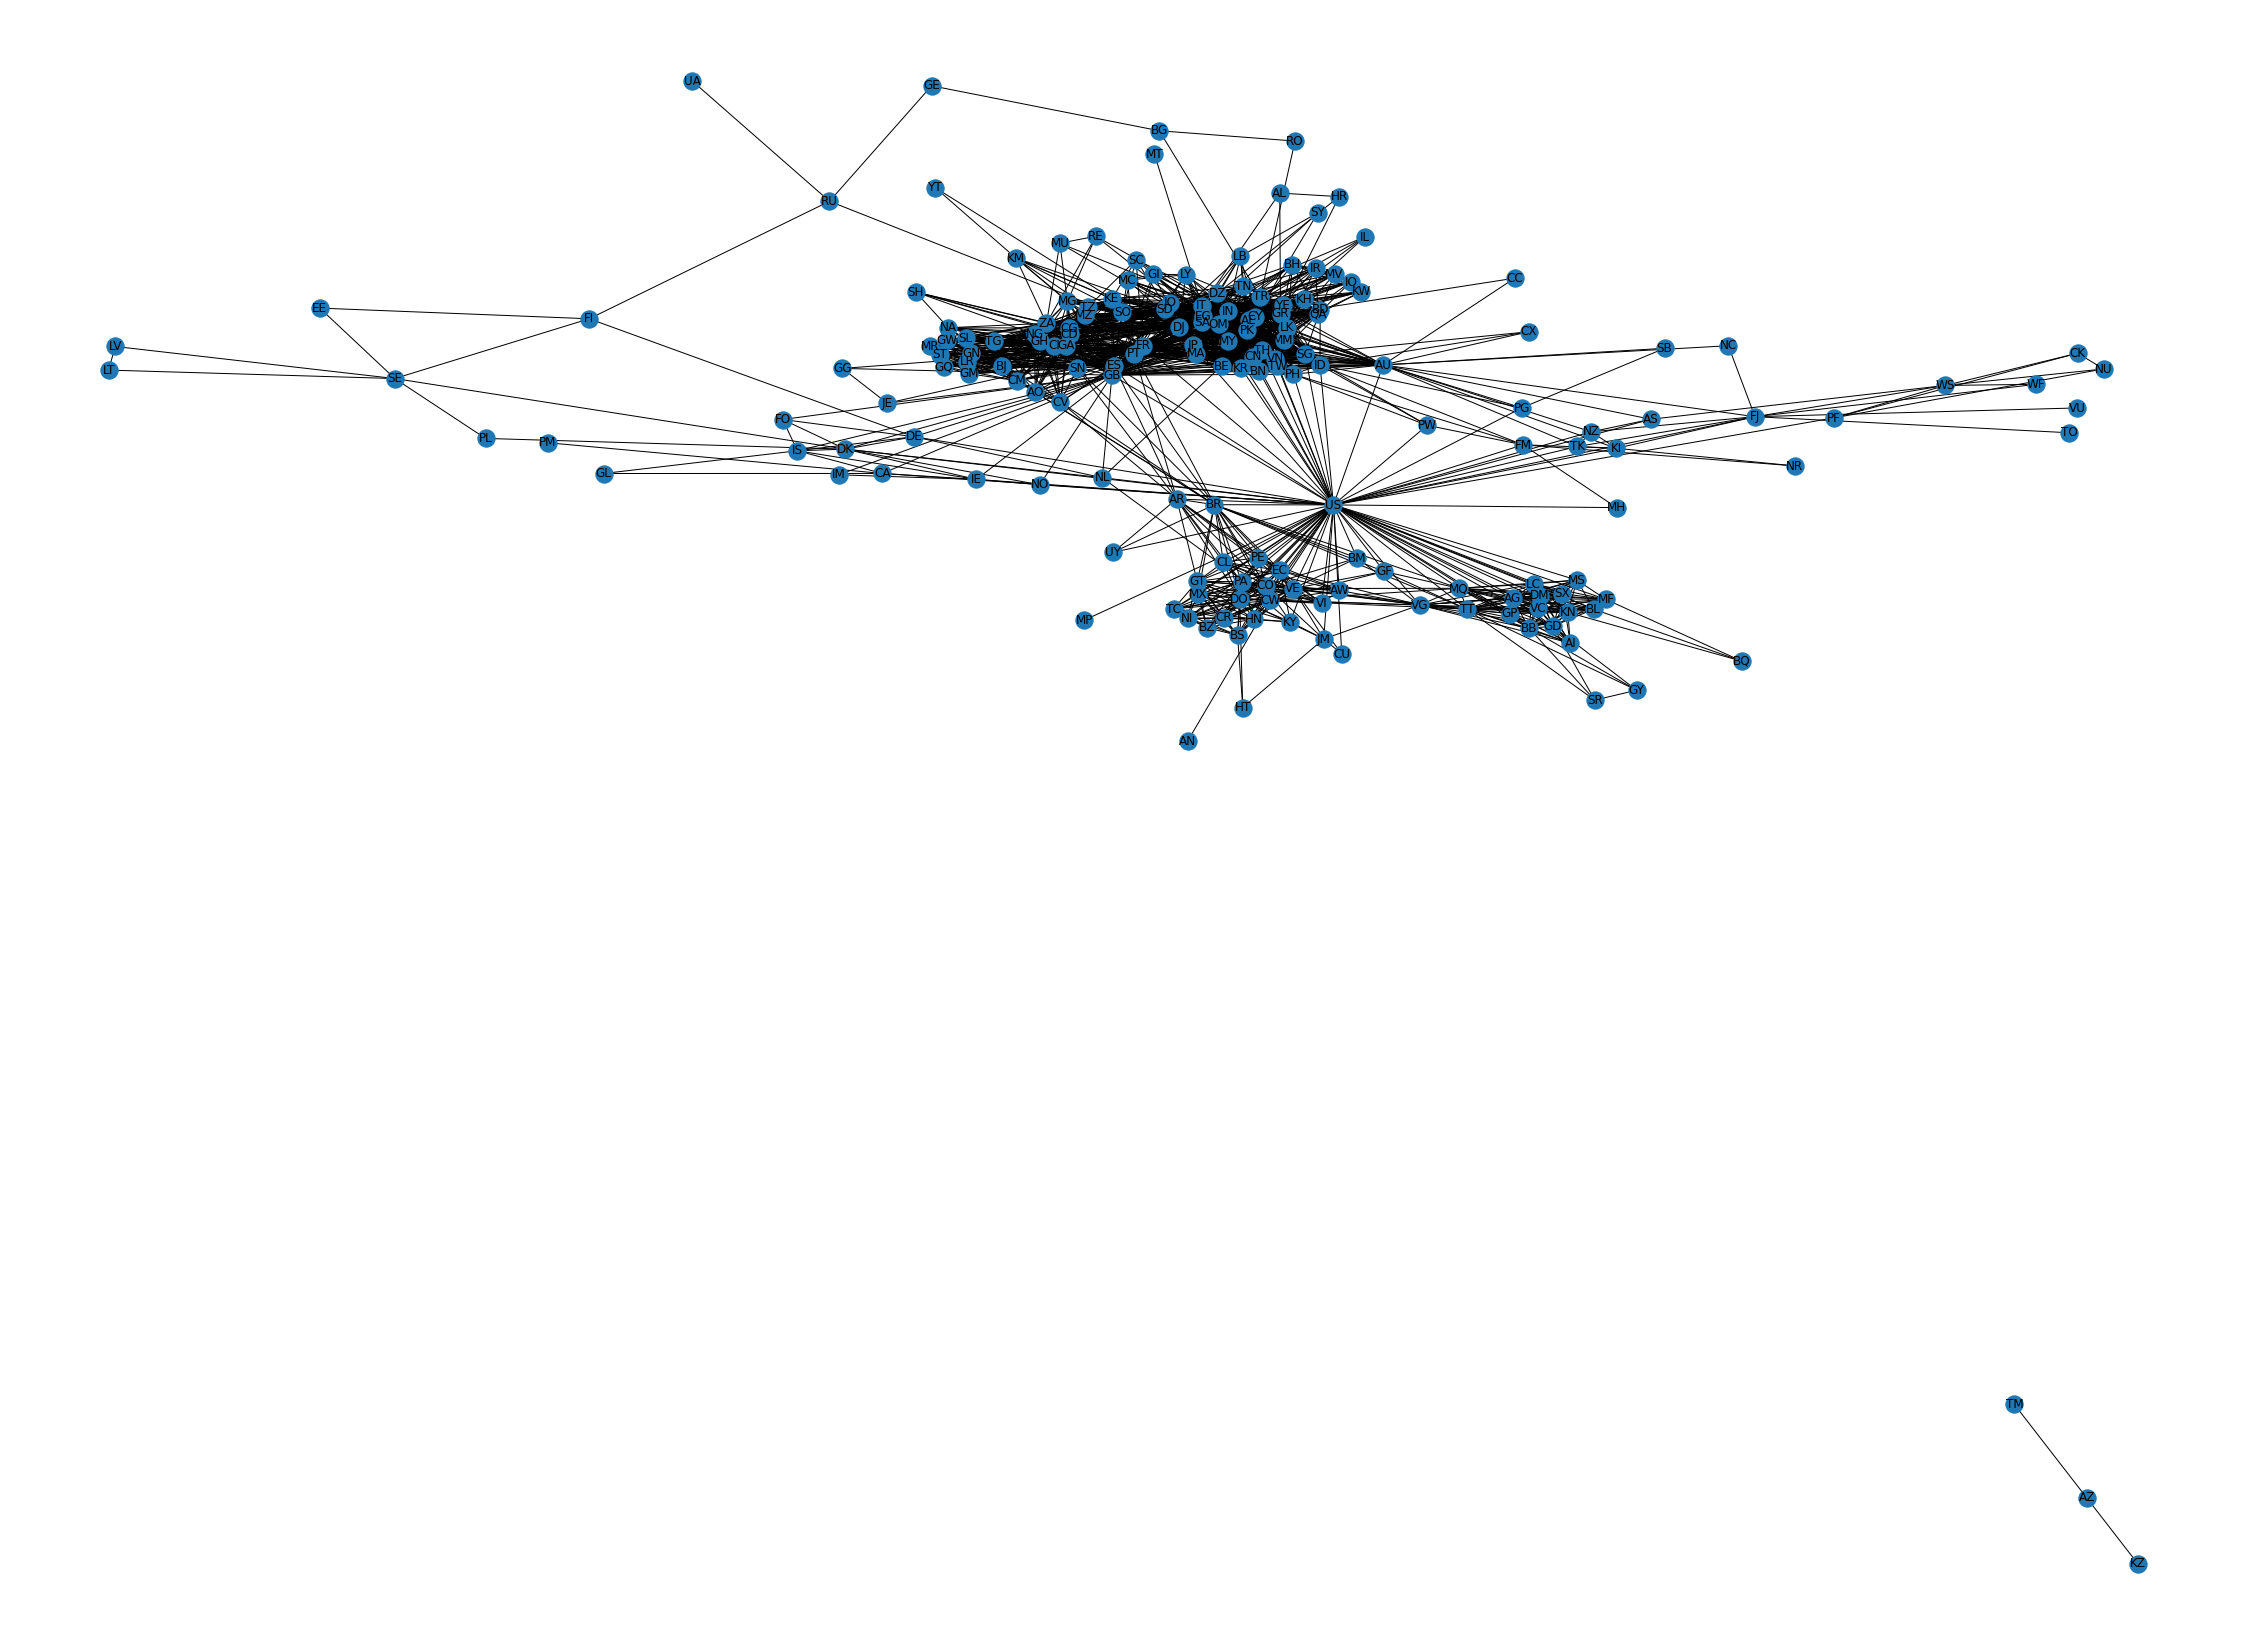

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(40, 30));
nx.draw(G, with_labels=True)

# Network density

In [10]:
density = nx.density(G)
density

0.10766828799615685

## Diameter (of largest subgraph)

In [11]:
# Next, use nx.connected_components to get the list of components,
# then use the max() command to find the largest one:
components = nx.connected_components(G)
largest_component = max(components, key=len)

# Create a "subgraph" of just the largest component
# Then calculate the diameter of the subgraph, just like you did with density.
#

subgraph = G.subgraph(largest_component)
diameter = nx.diameter(subgraph)
diameter

5

## Clustering coefficient
Transitivity is the ratio of all triangles over all possible triangles. A possible triangle exists when one person (Fox) knows two people (Fell and Whitehead). So transitivity, like density, expresses how interconnected a graph is in terms of a ratio of actual over possible connections. 

In [12]:
nx.transitivity(G)

0.6196921711415488

## Degree centrality

In [13]:
from operator import itemgetter

In [75]:
degree_dict = dict(G.degree(G.nodes()))
nx.set_node_attributes(G, degree_dict, 'degree')

In [15]:
def top_n (my_dict, n):
    sorted_dict = sorted(my_dict.items(), key=itemgetter(1), reverse=True)
    return sorted_dict[:n]

In [16]:
top_n(degree_dict, 20)

[('US', 75),
 ('FR', 67),
 ('PT', 66),
 ('EG', 64),
 ('SA', 62),
 ('GB', 62),
 ('IT', 60),
 ('OM', 59),
 ('DJ', 57),
 ('IN', 55),
 ('AE', 51),
 ('ES', 51),
 ('ZA', 44),
 ('MY', 43),
 ('PK', 42),
 ('LK', 42),
 ('AU', 42),
 ('TH', 40),
 ('CI', 39),
 ('NG', 39)]

## Betweeness centrality

In [17]:
betweenness_dict = nx.betweenness_centrality(G) # Run betweenness centrality
nx.set_node_attributes(G, betweenness_dict, 'betweenness')
top_n(betweenness_dict, 20)

[('US', 0.4282769897319584),
 ('GB', 0.12839363538346987),
 ('FR', 0.07763278719485613),
 ('AU', 0.07415679156762096),
 ('ES', 0.05563017589586403),
 ('PT', 0.04900666233452014),
 ('DK', 0.04795388699605631),
 ('FJ', 0.03888618663535116),
 ('JP', 0.035603992356645874),
 ('IT', 0.03535416430584014),
 ('BR', 0.03282519392382023),
 ('SE', 0.02660003392969249),
 ('TR', 0.026401523506826823),
 ('EG', 0.023851663682373514),
 ('MY', 0.02347791874248372),
 ('PF', 0.02170544874066359),
 ('RU', 0.02119868483593696),
 ('CA', 0.018888623046572666),
 ('ID', 0.01868197954102077),
 ('OM', 0.01830260708526684)]

## Eigenvector centrality

In [18]:
eigenvector_dict = nx.eigenvector_centrality(G) # Run eigenvector centrality
nx.set_node_attributes(G, eigenvector_dict, 'eigenvector')
top_n(eigenvector_dict, 20)

[('FR', 0.2007648803834015),
 ('EG', 0.19767189857579764),
 ('SA', 0.19646204393556463),
 ('PT', 0.19140436054473117),
 ('IT', 0.1902738080419346),
 ('OM', 0.18974179012456877),
 ('DJ', 0.18937158047698416),
 ('GB', 0.17932245045177436),
 ('IN', 0.17321947912724478),
 ('AE', 0.16727066760985598),
 ('PK', 0.1526529231614674),
 ('MY', 0.1525949597797222),
 ('TH', 0.148692027029392),
 ('LK', 0.1486637642732888),
 ('CN', 0.1420787704134298),
 ('ES', 0.1402826840237173),
 ('SG', 0.13944182301820285),
 ('MA', 0.13909316954122541),
 ('CY', 0.1381167179112819),
 ('GR', 0.13726615708896595)]

## Community detection

In [42]:
import community

In [47]:
communities = community.best_partition(G)
nx.set_node_attributes(G, communities, 'modularity')

In [48]:
G.nodes['US']

{'degree': 75,
 'betweenness': 0.4282769897319584,
 'eigenvector': 0.06958792884012892,
 'modularity': 5}

In [54]:
def eigenvector_in_class (class_n, top=3):
    # First get a list of just the nodes in that class
    class0 = [n for n in G.nodes() if G.nodes[n]['modularity'] == class_n]
    # Then create a dictionary of the eigenvector centralities of those nodes
    class0_eigenvector = {n:G.nodes[n]['eigenvector'] for n in class0}
    # Then sort that dictionary and print the first 5 results
    class0_sorted_by_eigenvector = sorted(class0_eigenvector.items(), key=itemgetter(1), reverse=True)
    return class0_sorted_by_eigenvector[:top]

eigenvector_in_class(4)

[('EG', 0.19767189857579764),
 ('SA', 0.19646204393556463),
 ('IT', 0.1902738080419346)]

In [66]:
communities_dict = {}
for node, group in communities.items():
    if group not in communities_dict:
        communities_dict[group] = [ node ]
    if group in communities_dict:
        member_lst = communities_dict[group]
        member_lst.append(node)
        communities_dict[group] = member_lst
communities_dict

{0: ['AZ', 'AZ', 'TM', 'KZ'],
 1: ['PM',
  'PM',
  'NO',
  'BG',
  'IE',
  'CA',
  'EE',
  'IS',
  'RU',
  'DK',
  'GE',
  'RO',
  'IM',
  'GL',
  'DE',
  'NL',
  'SE',
  'FI',
  'UA',
  'FO',
  'LV',
  'PL',
  'LT'],
 2: ['MF',
  'MF',
  'VC',
  'BB',
  'BQ',
  'AI',
  'GD',
  'TT',
  'MQ',
  'MS',
  'AG',
  'DM',
  'SX',
  'VG',
  'BL',
  'KN',
  'GP',
  'LC',
  'GY',
  'SR'],
 3: ['MG',
  'MG',
  'FR',
  'NA',
  'SC',
  'GN',
  'AO',
  'GM',
  'YT',
  'TZ',
  'SL',
  'SO',
  'CV',
  'CD',
  'SD',
  'MU',
  'ES',
  'TG',
  'PT',
  'CI',
  'GQ',
  'SN',
  'NG',
  'LR',
  'MZ',
  'GA',
  'CM',
  'GW',
  'RE',
  'GH',
  'BJ',
  'MR',
  'KM',
  'SH',
  'KE',
  'ZA',
  'ST',
  'CG'],
 4: ['BN',
  'BN',
  'GI',
  'MM',
  'IL',
  'DZ',
  'KR',
  'SA',
  'SG',
  'QA',
  'VN',
  'AE',
  'TN',
  'KH',
  'MA',
  'SY',
  'OM',
  'BE',
  'PK',
  'DJ',
  'JO',
  'BD',
  'CY',
  'GR',
  'CX',
  'TW',
  'PH',
  'ID',
  'JP',
  'YE',
  'IT',
  'BH',
  'LK',
  'IN',
  'GB',
  'EG',
  'LY',
  'KW',
  '